In [1]:
import netket
from flax.core.scope import CollectionFilter
from netket.utils.types import PyTree
from netket.operator import Squared
from functools import partial, lru_cache
from typing import Callable, Optional

import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

import netket as nk
from netket import jax as nkjax
from netket.operator import DiscreteOperator, Squared
from netket.stats import Stats
from netket.utils.types import PyTree
from netket.utils.dispatch import dispatch

# from nektet.vqs import _ex
from netket.vqs import expect_and_grad, expect_and_forces
from netket.vqs.mc.common import force_to_grad, get_local_kernel, get_local_kernel_arguments
from netket.stats import Stats
import time
import json
import matplotlib.pyplot as plt
import numpy as np
from netket.operator.spin import sigmax, sigmay,sigmaz
from netket.stats import Stats, statistics

In [2]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
# Define a 1d chain
L = 8
dis = 1
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
# ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
b=dis
a=-dis
Gamma = (b-a) * np.random.random_sample(L) + a

################################################################################
################################################################################
################################################################################
#이렇게 정의하는게 더 빨랑
ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
         + sigmay(hi,i)*sigmay(hi,(i+1)%L)
         + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
           for i in range(L)])
################################################################################
################################################################################
################################################################################
ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])

In [3]:
Et = np.random.uniform(low=0, high=L, size=None)
Et

6.710760623881723

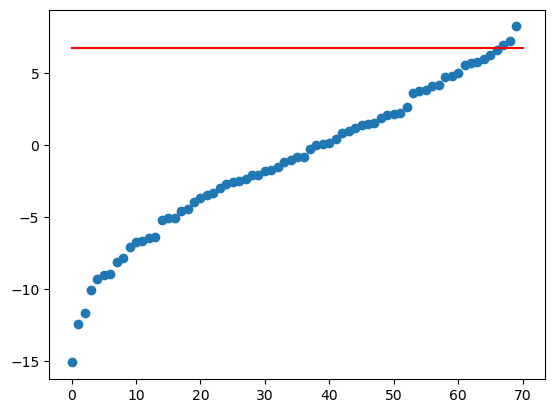

In [4]:
E, vec = np.linalg.eigh(ha.to_dense())
plt.scatter(range(len(E)),E)
plt.plot([0,len(E)],[Et,Et],'r')

In [5]:
E

array([-15.0831038 , -12.3900453 , -11.65130829, -10.08021078,
        -9.31267211,  -9.04601793,  -8.93930188,  -8.08941318,
        -7.86071686,  -7.08723563,  -6.74194617,  -6.66032959,
        -6.41978582,  -6.37460498,  -5.21854102,  -5.09031178,
        -5.07993372,  -4.5876508 ,  -4.44931023,  -3.9769765 ,
        -3.66007225,  -3.48021754,  -3.33167921,  -2.97319398,
        -2.68269296,  -2.5505974 ,  -2.4732439 ,  -2.36917614,
        -2.09543671,  -2.05054198,  -1.78186168,  -1.7076754 ,
        -1.5256281 ,  -1.17665774,  -1.038029  ,  -0.85990713,
        -0.85124265,  -0.24100253,  -0.031265  ,   0.091684  ,
         0.12140241,   0.41250534,   0.82990322,   0.98613494,
         1.20877864,   1.35682566,   1.47939295,   1.50543791,
         1.84695798,   2.08230565,   2.14979695,   2.21039858,
         2.65417359,   3.61451988,   3.72991608,   3.79042828,
         4.09110708,   4.17366386,   4.73889132,   4.78965707,
         4.98305835,   5.58033391,   5.66123155,   5.78

In [6]:
def add(x,y):
    return x+y


In [7]:
O_sparse = ha.to_sparse()
H_Et_sparse = (ha-Et).to_sparse()
H_Et_squ_sparse = ((ha-Et)@(ha-Et)).to_sparse()

In [8]:
from functools import partial
from typing import Callable, Optional

import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

from netket import jax as nkjax
from netket import config
from netket.stats import Stats
from netket.utils import mpi, dispatch
from netket.utils.types import PyTree

from netket.operator import (
    AbstractOperator,
    Squared,
)

from netket.vqs import expect_and_grad, expect_and_forces

# from ..common import force_to_grad, get_local_kernel_arguments, get_local_kernel

from netket.vqs import MCState


@expect_and_forces.dispatch
def expect_and_forces_kodo(  # noqa: F811
    vstate: MCState,
    Ô: AbstractOperator,
    chunk_size: None,
    *,
    mutable: CollectionFilter = False,
) -> tuple[Stats, PyTree]:
    σ, args = get_local_kernel_arguments(vstate, Ô)

    local_estimator_fun = get_local_kernel(vstate, Ô)

    Ō, Ō_grad, new_model_state = forces_expect_kodo(
        local_estimator_fun,
        vstate._apply_fun,
        mutable,
        vstate.parameters,
        vstate.model_state,
        σ,
        args,
    )

    if mutable is not False:
        vstate.model_state = new_model_state

    return Ō, Ō_grad


@partial(jax.jit, static_argnums=(0, 1, 2))
def forces_expect_kodo(
    local_value_kernel: Callable,
    model_apply_fun: Callable,
    mutable: CollectionFilter,
    parameters: PyTree,
    model_state: PyTree,
    σ: jnp.ndarray,
    local_value_args: PyTree,
) -> tuple[PyTree, PyTree]:
    n_chains = σ.shape[0]
    if σ.ndim >= 3:
        σ = jax.lax.collapse(σ, 0, 2)

    n_samples = σ.shape[0] * mpi.n_nodes

    O_loc = local_value_kernel(
        model_apply_fun,
        {"params": parameters, **model_state},
        σ,
        local_value_args,
    )

    Ō = statistics(O_loc.reshape((n_chains, -1)))

    O_loc -= Ō.mean

    # Then compute the vjp.
    # Code is a bit more complex than a standard one because we support
    # mutable state (if it's there)
    is_mutable = mutable is not False
    _, vjp_fun, *new_model_state = nkjax.vjp(
        lambda w: model_apply_fun({"params": w, **model_state}, σ, mutable=mutable),
        parameters,
        conjugate=True,
        has_aux=is_mutable,
    )
    Ō_grad = vjp_fun(jnp.conjugate(O_loc) / n_samples)[0]

    new_model_state = new_model_state[0] if is_mutable else None

    return (
        Ō,
        jax.tree_util.tree_map(lambda x: mpi.mpi_sum_jax(x)[0], Ō_grad),
        new_model_state,
    )

In [9]:
def variance(vsta, hamiltonian):
    return vsta.to_array().conj()@(hamiltonian@hamiltonian).to_sparse()@vsta.to_array() - (vsta.to_array().conj()@(hamiltonian).to_sparse()@vsta.to_array())**2

In [12]:
# Build the sampler
# sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
epochs = 20000


ma = nk.models.RBM(alpha=4, param_dtype=complex)
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max=1, n_chains=16)
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.001)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)


# The ground-state optimization loop
Target_ha = ha
gs = nk.VMC(
    hamiltonian=Target_ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(epochs, out='RBM')
end = time.time()

data=json.load(open("RBM.log"))
# variance(vs,ha)
# plt.plot(np.log10(data['Energy']['Variance']))

100%|█| 20000/20000 [45:58<00:00,  7.25it/s, Energy=-15.0797+0.0021j ± 0.0016 [σ


In [13]:
variance(vs,ha)

Array(0.01470887+5.63467743e-15j, dtype=complex128)